In [6]:
import os 
import string
from glob import glob 
import pandas as pd
import numpy as np
import xvec

import xarray as xr
import geopandas as gpd
import rasterio
import rioxarray as rio
import shapely.geometry


import folium
import leafmap.foliumap as leafmap
import matplotlib.pyplot as plt

### Load LAI

In [7]:
lai_files = glob("./lai_cropped/*.tif")

basename = []
for x in lai_files:
    name = os.path.basename(x)
    name = pd.to_datetime(name[-19:-4])
    basename.append(name)


time = xr.Variable('time', basename)
lai_da = xr.concat([rio.open_rasterio(f) for f in lai_files], dim=time)
lai_da = lai_da.sortby("time")
lai_ds = lai_da.to_dataset(dim="band").rename_vars({1:"lai"})
lai_ds

<xarray.Dataset> Size: 226MB
Dimensions:      (time: 77, y: 832, x: 881)
Coordinates:
  * x            (x) float64 7kB 6.989e+05 6.99e+05 ... 7.077e+05 7.077e+05
  * y            (y) float64 7kB 5.181e+06 5.181e+06 ... 5.173e+06 5.173e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 616B 2023-04-01T10:15:59 ... 2023-10-3...
Data variables:
    lai          (time, y, x) float32 226MB nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [353]:
lai_ds

<xarray.Dataset> Size: 226MB
Dimensions:      (time: 77, y: 832, x: 881)
Coordinates:
  * x            (x) float64 7kB 6.989e+05 6.99e+05 ... 7.077e+05 7.077e+05
  * y            (y) float64 7kB 5.181e+06 5.181e+06 ... 5.173e+06 5.173e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 616B 2023-04-01T10:15:59 ... 2023-10-3...
Data variables:
    lai          (time, y, x) float32 226MB nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

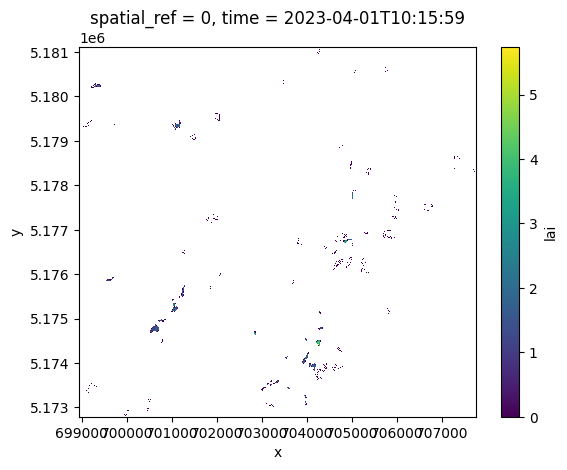

In [8]:
lai_ds["lai"].isel(time=0).plot()

### Load Sentinel-1 RTC

In [356]:
rtc_asc_files = glob("./RTC_asc_cropped/*.tif")
basename = []
for x in rtc_asc_files:
    name = os.path.basename(x)
    name = pd.to_datetime(name[-12:-4])
    basename.append(name)


time = xr.Variable('time', basename)
rtc_asc = xr.concat([rio.open_rasterio(f) for f in rtc_asc_files], dim=time)
rtc_asc = rtc_asc.sortby("time")
rtc_asc = rtc_asc.to_dataset(dim="band").rename_vars({1:"asc_vv", 2:"asc_vh"})
rtc_asc

<xarray.Dataset> Size: 381MB
Dimensions:      (time: 65, y: 832, x: 881)
Coordinates:
  * x            (x) float64 7kB 6.989e+05 6.99e+05 ... 7.077e+05 7.077e+05
  * y            (y) float64 7kB 5.181e+06 5.181e+06 ... 5.173e+06 5.173e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 520B 2023-03-05 2023-03-07 ... 2023-11-26
Data variables:
    asc_vv       (time, y, x) float32 191MB nan nan nan nan ... nan nan nan nan
    asc_vh       (time, y, x) float32 191MB nan nan nan nan ... nan nan nan nan
Attributes:
    STATISTICS_MAXIMUM:  8.5030002593994
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  -18.784999847412
    STATISTICS_STDDEV:   -9999
    AREA_OR_POINT:       Area
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('RTC_VV', 'RTC_VH')

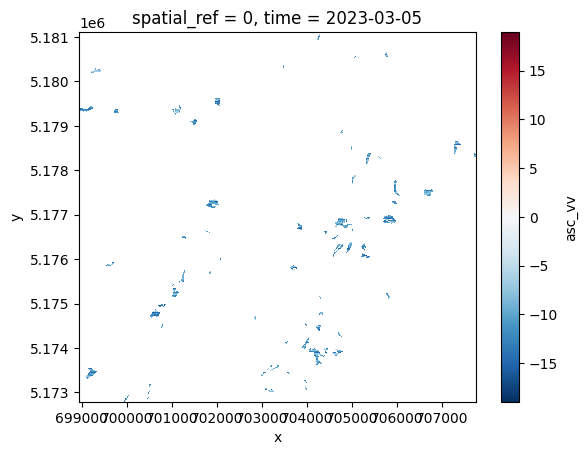

In [10]:
rtc_asc["asc_vv"].isel(time=0).plot()

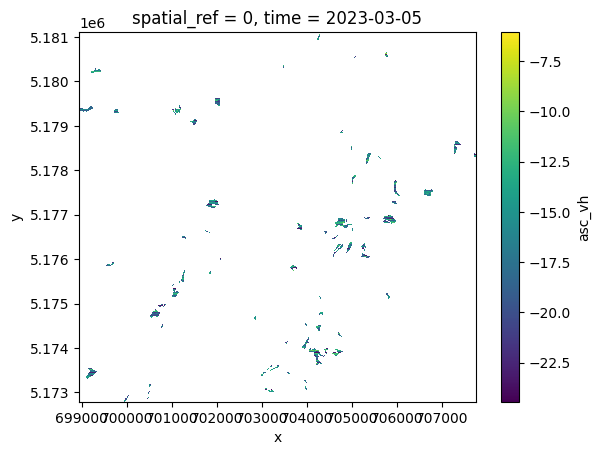

In [11]:
rtc_asc["asc_vh"].isel(time=0).plot()

In [12]:
rtc_dsc_files = glob("./RTC_dsc_cropped/*.tif")
basename = []
for x in rtc_dsc_files:
    name = os.path.basename(x)
    name = pd.to_datetime(name[-12:-4])
    basename.append(name)


time = xr.Variable('time', basename)
rtc_dsc = xr.concat([rio.open_rasterio(f) for f in rtc_dsc_files], dim=time)
rtc_dsc = rtc_dsc.sortby("time")
rtc_dsc = rtc_dsc.to_dataset(dim="band").rename_vars({1:"dsc_vv", 2:"dsc_vh"})
rtc_dsc

<xarray.Dataset> Size: 264MB
Dimensions:      (time: 45, y: 832, x: 881)
Coordinates:
  * x            (x) float64 7kB 6.989e+05 6.99e+05 ... 7.077e+05 7.077e+05
  * y            (y) float64 7kB 5.181e+06 5.181e+06 ... 5.173e+06 5.173e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 360B 2023-03-04 2023-03-11 ... 2023-11-30
Data variables:
    dsc_vv       (time, y, x) float32 132MB nan nan nan nan ... nan nan nan nan
    dsc_vh       (time, y, x) float32 132MB nan nan nan nan ... nan nan nan nan
Attributes:
    STATISTICS_MAXIMUM:  14.260999679565
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  -21.124000549316
    STATISTICS_STDDEV:   -9999
    AREA_OR_POINT:       Area
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('RTC_VV', 'RTC_VH')

### Load the farms

In [401]:
from shapely.geometry import box
farms = gpd.read_file("./shp/T_LAFIS_32632_buffered_classified_10percent.shp")
farms = farms.to_crs(epsg=4326)

dataset_box = box(11.604309, 46.679594, 11.727219, 46.751153)
T32TPS_farms = farms[farms.intersects(dataset_box)]
T32TPS_farms = T32TPS_farms.reset_index(drop=True)
print("There are ", T32TPS_farms.shape[0], " farms")


There are  66  farms


In [402]:
T32TPS_farms.head(5)

,ID,CODE,DESCR_IT,DESCR_DE,elev,northness,slope,area,face,class,geometry
0,1782222,AP2,Prato stabile,Wiese (Dauerwiese),1384.621242,-0.790552,18.553996,7238.380564,S,S_mont,"POLYGON ((11.60803 46.7457, 11.60802 46.74572,..."
1,2452708,AP2,Prato stabile,Wiese (Dauerwiese),610.494102,-0.466073,33.243051,1763.564030,S,S_coll,"MULTIPOLYGON (((11.62123 46.67986, 11.62125 46..."
2,2753189,AP2,Prato stabile,Wiese (Dauerwiese),605.398214,0.254297,9.608795,5781.321955,N,N_coll,"MULTIPOLYGON (((11.66388 46.70483, 11.66388 46..."
3,2286544,AP2,Prato stabile,Wiese (Dauerwiese),858.793483,-0.033078,15.239743,29644.776476,S,S_coll,"MULTIPOLYGON (((11.67739 46.71279, 11.67739 46..."
4,2881455,AP2,Prato stabile,Wiese (Dauerwiese),1059.817219,0.288833,9.422010,13395.827122,N,N_submont,"MULTIPOLYGON (((11.68467 46.70658, 11.68468 46..."


In [403]:
T32TPS_farms['centroid'] = T32TPS_farms['geometry'].centroid
T32TPS_farms['Lon'] = T32TPS_farms['centroid'].x
T32TPS_farms['Lat'] = T32TPS_farms['centroid'].y

# Create a map and check the location of each cluster
center_lat, center_lon =  T32TPS_farms['Lat'].mean(), T32TPS_farms['Lon'].mean()


map_farms = leafmap.Map(location=[center_lat, center_lon], zoom_start=13)
map_farms.add_xyz_service("qms.EOX::Maps - Sentinel-2 cloudless")

style_function = lambda x: {'fillColor': '#3366cc', 'color': '#3366cc'}

folium.GeoJson(T32TPS_farms['geometry'], style_function=style_function).add_to(map_farms)
map_farms

### Feature Engineering for S1

In [398]:
rtc_dsc['dsc_vv/vh'] = rtc_dsc['dsc_vv'] / rtc_dsc['dsc_vh']
rtc_dsc['dsc_rvi'] = (4*rtc_dsc['dsc_vv']) / (rtc_dsc['dsc_vv'] + rtc_dsc['dsc_vh'])
rtc_dsc

<xarray.Dataset> Size: 528MB
Dimensions:      (time: 45, y: 832, x: 881)
Coordinates:
  * x            (x) float64 7kB 6.989e+05 6.99e+05 ... 7.077e+05 7.077e+05
  * y            (y) float64 7kB 5.181e+06 5.181e+06 ... 5.173e+06 5.173e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 360B 2023-03-04 2023-03-11 ... 2023-11-30
Data variables:
    dsc_vv       (time, y, x) float32 132MB nan nan nan nan ... nan nan nan nan
    dsc_vh       (time, y, x) float32 132MB nan nan nan nan ... nan nan nan nan
    dsc_vv/vh    (time, y, x) float32 132MB nan nan nan nan ... nan nan nan nan
    dsc_rvi      (time, y, x) float32 132MB nan nan nan nan ... nan nan nan nan
Attributes:
    STATISTICS_MAXIMUM:  14.260999679565
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  -21.124000549316
    STATISTICS_STDDEV:   -9999
    AREA_OR_POINT:       Area
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('RTC_VV', 'RTC_VH')

In [399]:
rtc_asc['asc_vv/vh'] = rtc_asc['asc_vv'] / rtc_asc['asc_vh']
rtc_asc['asc_rvi'] = (4*rtc_asc['asc_vv']) / (rtc_asc['asc_vv'] + rtc_asc['asc_vh'])
rtc_asc

<xarray.Dataset> Size: 762MB
Dimensions:      (time: 65, y: 832, x: 881)
Coordinates:
  * x            (x) float64 7kB 6.989e+05 6.99e+05 ... 7.077e+05 7.077e+05
  * y            (y) float64 7kB 5.181e+06 5.181e+06 ... 5.173e+06 5.173e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 520B 2023-03-05 2023-03-07 ... 2023-11-26
Data variables:
    asc_vv       (time, y, x) float32 191MB nan nan nan nan ... nan nan nan nan
    asc_vh       (time, y, x) float32 191MB nan nan nan nan ... nan nan nan nan
    asc_vv/vh    (time, y, x) float32 191MB nan nan nan nan ... nan nan nan nan
    asc_rvi      (time, y, x) float32 191MB nan nan nan nan ... nan nan nan nan
Attributes:
    STATISTICS_MAXIMUM:  8.5030002593994
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  -18.784999847412
    STATISTICS_STDDEV:   -9999
    AREA_OR_POINT:       Area
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('RTC_VV', 'RTC_VH')

### Vector cubes Functions

In [404]:
# Get the same CRS
T32TPS_farms = T32TPS_farms.to_crs(epsg=32632)
T32TPS_farms.drop(columns="centroid", inplace=True)

#### Extract points 
We will extract LAI and S1 RTC values for the centroid of each farm.

In [405]:
T32TPS_farms = gpd.GeoDataFrame(T32TPS_farms, geometry='geometry')
T32TPS_farms["x"] = T32TPS_farms.geometry.centroid.x
T32TPS_farms["y"] = T32TPS_farms.geometry.centroid.y

In [406]:
from shapely.geometry import Point
# Create list of shapely Points
points = [Point(xy) for xy in zip(T32TPS_farms['x'], T32TPS_farms['y'])]

In [407]:
extracted_lai = lai_ds.xvec.extract_points(points, x_coords="x", y_coords="y")
extracted_lai

<xarray.Dataset> Size: 21kB
Dimensions:      (time: 77, geometry: 66)
Coordinates:
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 616B 2023-04-01T10:15:59 ... 2023-10-3...
  * geometry     (geometry) object 528B POINT (699317.9482542522 5180237.3201...
Data variables:
    lai          (time, geometry) float32 20kB 1.592 0.0 nan nan ... nan nan 0.0
Indexes:
    geometry  GeometryIndex (crs=None)
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [408]:
extracted_rtc_dsc = rtc_dsc.xvec.extract_points(points, x_coords="x", y_coords="y")
extracted_rtc_dsc

<xarray.Dataset> Size: 48kB
Dimensions:      (time: 45, geometry: 66)
Coordinates:
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 360B 2023-03-04 2023-03-11 ... 2023-11-30
  * geometry     (geometry) object 528B POINT (699317.9482542522 5180237.3201...
Data variables:
    dsc_vv       (time, geometry) float32 12kB -14.11 -12.9 ... -9.948 -13.16
    dsc_vh       (time, geometry) float32 12kB -20.86 -19.83 ... -17.43 -18.07
    dsc_vv/vh    (time, geometry) float32 12kB 0.6764 0.6506 ... 0.5709 0.7282
    dsc_rvi      (time, geometry) float32 12kB 1.614 1.577 1.646 ... 1.454 1.686
Indexes:
    geometry  GeometryIndex (crs=None)
Attributes:
    STATISTICS_MAXIMUM:  14.260999679565
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  -21.124000549316
    STATISTICS_STDDEV:   -9999
    AREA_OR_POINT:       Area
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('RTC_VV', 'RTC_VH')

In [409]:
extracted_rtc_asc = rtc_asc.xvec.extract_points(points, x_coords="x", y_coords="y")
extracted_rtc_asc

<xarray.Dataset> Size: 70kB
Dimensions:      (time: 65, geometry: 66)
Coordinates:
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 520B 2023-03-05 2023-03-07 ... 2023-11-26
  * geometry     (geometry) object 528B POINT (699317.9482542522 5180237.3201...
Data variables:
    asc_vv       (time, geometry) float32 17kB -14.53 -10.98 ... -10.16 -9.953
    asc_vh       (time, geometry) float32 17kB -20.94 -18.18 ... -16.47 -18.97
    asc_vv/vh    (time, geometry) float32 17kB 0.6941 0.6043 ... 0.6169 0.5248
    asc_rvi      (time, geometry) float32 17kB 1.639 1.507 1.604 ... 1.526 1.377
Indexes:
    geometry  GeometryIndex (crs=None)
Attributes:
    STATISTICS_MAXIMUM:  8.5030002593994
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  -18.784999847412
    STATISTICS_STDDEV:   -9999
    AREA_OR_POINT:       Area
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('RTC_VV', 'RTC_VH')

In [544]:
### Extract random points 
# Get the bounding box of the farm GeoDataFrame
bbox = T32TPS_farms.total_bounds  # returns (minx, miny, maxx, maxy)
minx, miny, maxx, maxy = bbox

# Sample N random points in the bounding box
def random_points_in_bbox(minx, miny, maxx, maxy, n):
    xs = np.random.uniform(minx, maxx, n)
    ys = np.random.uniform(miny, maxy, n)
    return [shapely.geometry.Point(x, y) for x, y in zip(xs, ys)]

# Generate the points
random_points = random_points_in_bbox(minx, miny, maxx, maxy, 500)
extracted_lai = lai_ds.xvec.extract_points(random_points, x_coords="x", y_coords="y")
extracted_lai

<xarray.Dataset> Size: 159kB
Dimensions:      (time: 77, geometry: 500)
Coordinates:
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 616B 2023-04-01T10:15:59 ... 2023-10-3...
  * geometry     (geometry) object 4kB POINT (700925.0323585627 5180496.57625...
Data variables:
    lai          (time, geometry) float32 154kB nan nan nan nan ... nan nan nan
Indexes:
    geometry  GeometryIndex (crs=None)
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

#### Zonal statistcs 

In [410]:
# Zonal statistcs 
aggregated_lai_farms = lai_ds.xvec.zonal_stats(
    T32TPS_farms.geometry,
    x_coords="x",
    y_coords="y",
    stats="mean",
    name = "farm"
)
aggregated_lai_farms

<xarray.Dataset> Size: 21kB
Dimensions:      (farm: 66, time: 77)
Coordinates:
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 616B 2023-04-01T10:15:59 ... 2023-10-3...
  * farm         (farm) object 528B POLYGON ((699211.6412465982 5180209.02586...
Data variables:
    lai          (farm, time) float32 20kB 1.647 1.319 1.41 nan ... nan nan nan
Indexes:
    farm     GeometryIndex (crs=EPSG:32632)
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [411]:
# Zonal statistcs 
aggregated_rtc_dsc_farms = rtc_dsc.xvec.zonal_stats(
    T32TPS_farms.geometry,
    stats=["mean", "sum"],
    x_coords="x",
    y_coords="y",
    name = "farm"
)
aggregated_rtc_dsc_farms

<xarray.Dataset> Size: 96kB
Dimensions:           (zonal_statistics: 2, farm: 66, time: 45)
Coordinates:
    spatial_ref       int64 8B 0
  * time              (time) datetime64[ns] 360B 2023-03-04 ... 2023-11-30
  * zonal_statistics  (zonal_statistics) <U4 32B 'mean' 'sum'
  * farm              (farm) object 528B POLYGON ((699211.6412465982 5180209....
Data variables:
    dsc_vv            (farm, zonal_statistics, time) float32 24kB -10.46 ... ...
    dsc_vh            (farm, zonal_statistics, time) float32 24kB -17.79 ... ...
    dsc_vv/vh         (farm, zonal_statistics, time) float32 24kB 0.5775 ... ...
    dsc_rvi           (farm, zonal_statistics, time) float32 24kB 1.447 ... 1...
Indexes:
    farm     GeometryIndex (crs=EPSG:32632)
Attributes:
    STATISTICS_MAXIMUM:  14.260999679565
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  -21.124000549316
    STATISTICS_STDDEV:   -9999
    AREA_OR_POINT:       Area
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('RTC_VV', 'RTC_VH')

In [412]:
# Zonal statistcs 
aggregated_rtc_asc_farms = rtc_asc.xvec.zonal_stats(
    T32TPS_farms.geometry,
    stats=["mean", "sum"],
    x_coords="x",
    y_coords="y",
    name = "farm"
)
aggregated_rtc_asc_farms

<xarray.Dataset> Size: 138kB
Dimensions:           (zonal_statistics: 2, farm: 66, time: 65)
Coordinates:
    spatial_ref       int64 8B 0
  * time              (time) datetime64[ns] 520B 2023-03-05 ... 2023-11-26
  * zonal_statistics  (zonal_statistics) <U4 32B 'mean' 'sum'
  * farm              (farm) object 528B POLYGON ((699211.6412465982 5180209....
Data variables:
    asc_vv            (farm, zonal_statistics, time) float32 34kB -9.565 ... ...
    asc_vh            (farm, zonal_statistics, time) float32 34kB -16.51 ... ...
    asc_vv/vh         (farm, zonal_statistics, time) float32 34kB 0.5719 ... ...
    asc_rvi           (farm, zonal_statistics, time) float32 34kB 1.44 ... 13.99
Indexes:
    farm     GeometryIndex (crs=EPSG:32632)
Attributes:
    STATISTICS_MAXIMUM:  8.5030002593994
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  -18.784999847412
    STATISTICS_STDDEV:   -9999
    AREA_OR_POINT:       Area
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('RTC_VV', 'RTC_VH')

In [518]:
aggregated_rtc_dsc_farms = rtc_dsc.xvec.zonal_stats(
    T32TPS_farms.geometry,
    stats="mean",
    x_coords="x",
    y_coords="y",
    name = "farm",
    all_touched=True
)


aggregated_rtc_asc_farms = rtc_asc.xvec.zonal_stats(
    T32TPS_farms.geometry,
    stats="mean",
    x_coords="x",
    y_coords="y",
    name = "farm",
    all_touched=True
)

In [519]:
??rtc_dsc.xvec.zonal_stats

Signature:
rtc_dsc.xvec.zonal_stats(
    geometry: 'Sequence[shapely.Geometry]',
    x_coords: 'Hashable',
    y_coords: 'Hashable',
    stats: 'str | Callable | Sequence[str | Callable | tuple]' = 'mean',
    name: 'str' = 'geometry',
    index: 'bool | None' = None,
    method: 'str' = 'rasterize',
    all_touched: 'bool' = False,
    n_jobs: 'int' = -1,
    **kwargs: 'dict[str, Any]',
) -> 'xr.DataArray | xr.Dataset'
Source:   
    def zonal_stats(
        self,
        geometry: Sequence[shapely.Geometry],
        x_coords: Hashable,
        y_coords: Hashable,
        stats: str | Callable | Sequence[str | Callable | tuple] = "mean",
        name: str = "geometry",
        index: bool | None = None,
        method: str = "rasterize",
        all_touched: bool = False,
        n_jobs: int = -1,
        **kwargs: dict[str, Any],
    ) -> xr.DataArray | xr.Dataset:
        """Extract the values from a dataset indexed by a set of geometries

        Given an object indexed by x and y 

#### Indexing & Selecting Data

In [414]:
T32TPS_farms.head(3)

,ID,CODE,DESCR_IT,DESCR_DE,elev,northness,slope,area,face,class,geometry,Lon,Lat,x,y
0,1782222,AP2,Prato stabile,Wiese (Dauerwiese),1384.621242,-0.790552,18.553996,7238.380564,S,S_mont,"POLYGON ((699211.641 5180209.026, 699210.869 5...",11.609432,46.745927,699317.948254,5.180237e+06
1,2452708,AP2,Prato stabile,Wiese (Dauerwiese),610.494102,-0.466073,33.243051,1763.564030,S,S_coll,"MULTIPOLYGON (((700463.641 5172926.726, 700464...",11.621647,46.681033,700491.273765,5.173058e+06
2,2753189,AP2,Prato stabile,Wiese (Dauerwiese),605.398214,0.254297,9.608795,5781.321955,N,N_coll,"MULTIPOLYGON (((703631.585 5175810.696, 703631...",11.664703,46.704917,703693.920050,5.175822e+06


In [415]:
# Select specific farm
farm_id = 1782222
selected_farm = T32TPS_farms[T32TPS_farms["ID"] ==  farm_id]
geom = selected_farm.geometry[0]
selected_farm

,ID,CODE,DESCR_IT,DESCR_DE,elev,northness,slope,area,face,class,geometry,Lon,Lat,x,y
0,1782222,AP2,Prato stabile,Wiese (Dauerwiese),1384.621242,-0.790552,18.553996,7238.380564,S,S_mont,"POLYGON ((699211.641 5180209.026, 699210.869 5...",11.609432,46.745927,699317.948254,5.180237e+06


In [370]:
# Select S1 ASC RTC data based on the geometry of the selected farm
aggregated_rtc_asc_farms.sel(farm=[geom])

<xarray.Dataset> Size: 1kB
Dimensions:      (farm: 1, time: 65)
Coordinates:
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 520B 2023-03-05 2023-03-07 ... 2023-11-26
  * farm         (farm) object 8B POLYGON ((699211.6412465982 5180209.0258600...
Data variables:
    asc_vv       (farm, time) float32 260B -9.565 -10.44 ... -9.466 -10.86
    asc_vh       (farm, time) float32 260B -16.51 -17.17 ... -14.73 -17.52
Indexes:
    farm     GeometryIndex (crs=EPSG:32632)
Attributes:
    STATISTICS_MAXIMUM:  8.5030002593994
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  -18.784999847412
    STATISTICS_STDDEV:   -9999
    AREA_OR_POINT:       Area
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('RTC_VV', 'RTC_VH')

In [371]:
# Select LAI data within 2.5 km around the geometry of the selected farm
aggregated_lai_farms.xvec.query("farm", [geom.buffer(2500)])

<xarray.Dataset> Size: 2kB
Dimensions:      (farm: 5, time: 77)
Coordinates:
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 616B 2023-04-01T10:15:59 ... 2023-10-3...
  * farm         (farm) object 40B POLYGON ((701414.5475881266 5179099.898371...
Data variables:
    lai          (farm, time) float32 2kB nan 3.036 3.396 nan ... nan nan nan
Indexes:
    farm     GeometryIndex (crs=EPSG:32632)
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

### Data cleaning, Matching with 3-day tolerance

In [520]:
# Initialize storage
matched_lai = []
matched_asc = []
matched_dsc = []
## to store the mathced times
matched_times_asc = [] 
matched_times_dsc = []
matched_times = []

# Tolerance in days
tolerance = 3



# iterate over the time coordinates of LAI dataset
for idx, t1 in enumerate(aggregated_lai_farms.time.values):
    # find the corresponding time coordinates in S1 RTC dataset within the tolerance

    # Match with S1 asc
    asc_time_diff = np.abs((aggregated_rtc_asc_farms.time.values - t1)) / np.timedelta64(1, 'D')
    dsc_time_diff = np.abs((aggregated_rtc_dsc_farms.time.values - t1)) / np.timedelta64(1, 'D') 

    asc_mask = asc_time_diff <= tolerance
    dsc_mask = dsc_time_diff <= tolerance

    
    if np.any(asc_mask) and np.any(dsc_mask):
        asc_time = aggregated_rtc_asc_farms.time.values[asc_mask][-1]
        dsc_time = aggregated_rtc_dsc_farms.time.values[dsc_mask][-1]
        
        if (asc_time not in matched_times_asc) and (dsc_time not in matched_times_dsc):  #(not np.isin(asc_time[-1], matched_times_asc)) and (not np.isin(dsc_time[-1], matched_times_dsc)):
            #print(t1)
            matched_lai.append(aggregated_lai_farms.sel(time=t1))
            matched_asc.append(aggregated_rtc_asc_farms.sel(time=asc_time))
            matched_dsc.append(aggregated_rtc_dsc_farms.sel(time=dsc_time))

            matched_times_asc.append(asc_time)
            matched_times_dsc.append(dsc_time)
            matched_times.append(t1)


In [521]:
# concatenate the matched data
if matched_lai:
    merged_lai = xr.concat(matched_lai, dim='concat_dim')
else:
    merged_lai = xr.Dataset()
    
if matched_asc:
    merged_asc = xr.concat(matched_asc, dim='concat_dim')
else:
    merged_asc = xr.Dataset()

if matched_dsc:
    merged_dsc = xr.concat(matched_dsc, dim='concat_dim')
else:
    merged_dsc = xr.Dataset()

In [522]:
# merge the concatenated data
if not merged_lai.equals(xr.Dataset()) and not merged_asc.equals(xr.Dataset()) and not merged_dsc.equals(xr.Dataset()):
    merged_ds = xr.merge([merged_lai, merged_asc, merged_dsc], compat='override')
else:
    merged_ds = xr.Dataset()

In [523]:
merged_ds = merged_ds.assign_coords(concat_dim=merged_ds.time.values)
merged_ds = merged_ds.drop_vars('time')
merged_ds = merged_ds.rename_dims({'concat_dim': 'time'})
merged_ds = merged_ds.rename_vars({'concat_dim': 'time'})
merged_ds

<xarray.Dataset> Size: 79kB
Dimensions:      (time: 33, farm: 66)
Coordinates:
    spatial_ref  int64 8B 0
  * farm         (farm) object 528B POLYGON ((699211.6412465982 5180209.02586...
  * time         (time) datetime64[ns] 264B 2023-04-03T10:05:51 ... 2023-10-3...
Data variables:
    lai          (time, farm) float32 9kB 1.319 0.3376 0.956 ... nan nan nan
    asc_vv       (time, farm) float32 9kB -10.78 -11.69 -10.86 ... -8.567 -8.646
    asc_vh       (time, farm) float32 9kB -16.65 -17.78 -17.75 ... -14.48 -14.37
    asc_vv/vh    (time, farm) float32 9kB 0.6434 0.6592 0.6098 ... 0.5894 0.6018
    asc_rvi      (time, farm) float32 9kB 1.557 1.585 1.51 ... 1.467 1.477 1.501
    dsc_vv       (time, farm) float32 9kB -12.5 -12.48 -12.31 ... -9.8 -8.988
    dsc_vh       (time, farm) float32 9kB -18.14 -19.01 -18.53 ... -15.84 -14.53
    dsc_vv/vh    (time, farm) float32 9kB 0.691 0.6566 0.6626 ... 0.6182 0.6174
    dsc_rvi      (time, farm) float32 9kB 1.631 1.579 1.588 ... 1.525 1.522
Indexes:
    farm     GeometryIndex (crs=EPSG:32632)
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [524]:
# from datetime import timedelta

# # New dataset to store the merged data
# matched_ds1 = []
# matched_ds2 = []
# matched_ds3 = []

# # Tolerance in days
# tolerance = 3
# matched_times_asc = [] # to store the mathced times
# matched_times_dsc = []

# # iterate over the time coordinates of LAI dataset
# for idx, t1 in enumerate(aggregated_lai_farms.time.values):
#     # find the corresponding time coordinates in S1 RTC dataset within the tolerance

#     # Match with S1 asc
#     #time_diff = np.abs((aggregated_rtc_asc_farms.time.values - t1).astype('timedelta64[D]').astype(int))
#     time_diff = np.abs((aggregated_rtc_asc_farms.time.values - t1)) / np.timedelta64(1, 'D')
#     mask = time_diff <= tolerance

#     # if there are matches, merge the data
#     if np.any(mask):
#         t2 = aggregated_rtc_asc_farms.time.values[mask]
#         if t2[-1] not in matched_times_asc:
#             #print(t2)
#             matched_times_asc.append(t2[-1])
#             matched_ds1.append(aggregated_lai_farms.sel(time=t1))
#             matched_ds2.append(aggregated_rtc_asc_farms.sel(time=t2[-1]))
            
# # concatenate the matched data
# if matched_ds1:
#     merged_ds1 = xr.concat(matched_ds1, dim='concat_dim')
# else:
#     merged_ds1 = xr.Dataset()
    
# if matched_ds2:
#     merged_ds2 = xr.concat(matched_ds2, dim='concat_dim')
# else:
#     merged_ds2 = xr.Dataset()


# # merge the concatenated data
# if not merged_ds1.equals(xr.Dataset()) and not merged_ds2.equals(xr.Dataset()):
#     merged_ds = xr.merge([merged_ds1, merged_ds2], compat='override')
# else:
#     merged_ds = xr.Dataset()


# merged_ds = merged_ds.assign_coords(concat_dim=merged_ds.time.values)
# merged_ds = merged_ds.drop_vars('time')
# merged_ds = merged_ds.rename_dims({'concat_dim': 'time'})
# merged_ds = merged_ds.rename_vars({'concat_dim': 'time'})
# merged_ds

In [525]:
       
# # New dataset to store the merged data
# matched_ds1 = []
# matched_ds3 = []

# # Tolerance in days
# tolerance = 3
# matched_times_dsc = []

# # iterate over the time coordinates of first Merged dataset
# for idx, t1 in enumerate(merged_ds.time.values):
#     # find the corresponding time coordinates in S1 RTC dataset within the tolerance

#     # Match with S1 Dsc
#     #time_diff = np.abs((aggregated_rtc_dsc_farms.time.values - t1).astype('timedelta64[D]').astype(int))
#     time_diff = np.abs((aggregated_rtc_dsc_farms.time.values - t1)) / np.timedelta64(1, 'D')
#     mask = time_diff <= tolerance

#     # if there are matches, merge the data
#     if np.any(mask):
#         t3 = aggregated_rtc_dsc_farms.time.values[mask]
#         if t3[-1] not in matched_times_dsc:
#             matched_times_dsc.append(t3[-1])
#             matched_ds1.append(merged_ds.sel(time=t1))
#             matched_ds3.append(aggregated_rtc_dsc_farms.sel(time=t3[-1]))


# # concatenate the matched data
# if matched_ds1:
#     merged_ds1 = xr.concat(matched_ds1, dim='concat_dim')
# else:
#     merged_ds1 = xr.Dataset()
    
# if matched_ds3:
#     merged_ds3 = xr.concat(matched_ds3, dim='concat_dim')
# else:
#     merged_ds3 = xr.Dataset()


# # merge the concatenated data
# if not merged_ds1.equals(xr.Dataset()) and not merged_ds3.equals(xr.Dataset()):
#     merged_ds = xr.merge([merged_ds1, merged_ds3], compat='override')
# else:
#     merged_ds = xr.Dataset()


# merged_ds = merged_ds.assign_coords(concat_dim=merged_ds.time.values)
# merged_ds = merged_ds.drop_vars('time')
# merged_ds = merged_ds.rename_dims({'concat_dim': 'time'})
# merged_ds = merged_ds.rename_vars({'concat_dim': 'time'})
# merged_ds

### Modeling

#### Reformate the data into data frame to be used for Random Forest 

In [526]:
variable_names = list(merged_ds.data_vars.keys())

In [527]:
df = merged_ds.xvec.to_geodataframe()
df = df.reset_index()
df['Day_of_Year'] = df['time'].dt.dayofyear
df_output = df
df_output
################ this is when we have multiple zonal stats
#df_pivot = df.pivot_table(index=['farm', 'Day_of_Year'], columns=['zonal_statistics'], values=variable_names) #, 
#df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]
#df_output = df_pivot.reset_index()
#df_output

,time,farm,lai,spatial_ref,asc_vv,asc_vh,asc_vv/vh,asc_rvi,dsc_vv,dsc_vh,dsc_vv/vh,dsc_rvi,Day_of_Year
0,2023-04-03 10:05:51,"POLYGON ((699211.641 5180209.026, 699210.869 5...",1.319309,0,-10.776989,-16.649954,0.643431,1.557189,-12.497297,-18.138912,0.690954,1.630548,93
1,2023-04-03 10:05:51,"MULTIPOLYGON (((700463.641 5172926.726, 700464...",0.337563,0,-11.686157,-17.777981,0.659239,1.585341,-12.483173,-19.013706,0.656611,1.579153,93
2,2023-04-03 10:05:51,"MULTIPOLYGON (((703631.585 5175810.696, 703631...",0.955983,0,-10.855891,-17.747578,0.609809,1.509823,-12.313130,-18.533188,0.662624,1.588195,93
3,2023-04-03 10:05:51,"MULTIPOLYGON (((704634.201 5176729.77, 704634....",1.678734,0,-11.117980,-17.020344,0.653690,1.575762,-12.477583,-19.506088,0.639474,1.554633,93
4,2023-04-03 10:05:51,"MULTIPOLYGON (((705214.265 5176058.786, 705214...",1.886288,0,-11.066588,-16.827057,0.662476,1.583248,-11.879721,-18.958603,0.624119,1.531244,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173,2023-10-30 10:11:41,"POLYGON ((700791.058 5174516.022, 700791.729 5...",NaN,0,-8.495818,-14.564775,0.583936,1.470232,-8.568682,-13.959909,0.607526,1.502174,303
2174,2023-10-30 10:11:41,"POLYGON ((701414.548 5179099.898, 701479.18 51...",NaN,0,-8.596035,-14.460350,0.594618,1.482259,-9.433964,-15.181145,0.621606,1.527387,303
2175,2023-10-30 10:11:41,"POLYGON ((698941.27 5179380.93, 698951.265 517...",NaN,0,-8.378937,-14.398633,0.582543,1.467066,-9.727337,-15.899103,0.605726,1.502873,303
2176,2023-10-30 10:11:41,"POLYGON ((703250.839 5173022.998, 703237.801 5...",NaN,0,-8.566709,-14.475709,0.589406,1.476956,-9.800129,-15.844146,0.618247,1.525401,303


In [528]:
df_farms = df_output.groupby(["farm","Day_of_Year"])
df_farms.first()

time  \
farm                                              Day_of_Year                       
POLYGON ((699931.79 5172798.306, 699939.94 517... 93          2023-04-03 10:05:51   
                                                  98          2023-04-08 10:05:59   
                                                  103         2023-04-13 10:05:51   
                                                  108         2023-04-18 10:05:59   
                                                  116         2023-04-26 10:16:01   
...                                                                           ...   
MULTIPOLYGON (((703939.028 5173255.061, 703938... 261         2023-09-18 10:16:49   
                                                  266         2023-09-23 10:17:31   
                                                  271         2023-09-28 10:17:19   
                                                  296         2023-10-23 10:21:01   
                                                  303         2023-10-30 10:11:41   

                                                                    lai  \
farm                                              Day_of_Year             
POLYGON ((699931.79 5172798.306, 699939.94 517... 93           1.400476   
                                                  98                NaN   
                                                  103               NaN   
                                                  108               NaN   
                                                  116               NaN   
...                                                                 ...   
MULTIPOLYGON (((703939.028 5173255.061, 703938... 261               NaN   
                                                  266               NaN   
                                                  271          4.467466   
                                                  296          0.888750   
                                                  303               NaN   

                                                               spatial_ref  \
farm                                              Day_of_Year                
POLYGON ((699931.79 5172798.306, 699939.94 517... 93                     0   
                                                  98                     0   
                                                  103                    0   
                                                  108                    0   
                                                  116                    0   
...                                                                    ...   
MULTIPOLYGON (((703939.028 5173255.061, 703938... 261                    0   
                                                  266                    0   
                                                  271                    0   
                                                  296                    0   
                                                  303                    0   

                                                                  asc_vv  \
farm                                              Day_of_Year              
POLYGON ((699931.79 5172798.306, 699939.94 517... 93          -10.870229   
                                                  98           -9.323960   
                                                  103         -10.567999   
                                                  108         -10.887287   
                                                  116         -10.353980   
...                                                                  ...   
MULTIPOLYGON (((703939.028 5173255.061, 703938... 261          -9.911844   
                                                  266          -8.916283   
                                                  271          -9.955079   
                                                  296          -9.150984   
                                                  303          -8.92

In [529]:
df_output.to_csv("./final_df_python.csv", index=False)

In [530]:
lai_df = df_output.dropna().reset_index(drop=True)

In [531]:
lai_df

,time,farm,lai,spatial_ref,asc_vv,asc_vh,asc_vv/vh,asc_rvi,dsc_vv,dsc_vh,dsc_vv/vh,dsc_rvi,Day_of_Year
0,2023-04-03 10:05:51,"POLYGON ((699211.641 5180209.026, 699210.869 5...",1.319309,0,-10.776989,-16.649954,0.643431,1.557189,-12.497297,-18.138912,0.690954,1.630548,93
1,2023-04-03 10:05:51,"MULTIPOLYGON (((700463.641 5172926.726, 700464...",0.337563,0,-11.686157,-17.777981,0.659239,1.585341,-12.483173,-19.013706,0.656611,1.579153,93
2,2023-04-03 10:05:51,"MULTIPOLYGON (((703631.585 5175810.696, 703631...",0.955983,0,-10.855891,-17.747578,0.609809,1.509823,-12.313130,-18.533188,0.662624,1.588195,93
3,2023-04-03 10:05:51,"MULTIPOLYGON (((704634.201 5176729.77, 704634....",1.678734,0,-11.117980,-17.020344,0.653690,1.575762,-12.477583,-19.506088,0.639474,1.554633,93
4,2023-04-03 10:05:51,"MULTIPOLYGON (((705214.265 5176058.786, 705214...",1.886288,0,-11.066588,-16.827057,0.662476,1.583248,-11.879721,-18.958603,0.624119,1.531244,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,2023-10-23 10:21:01,"POLYGON ((704561.872 5173876.393, 704562.85 51...",1.732391,0,-8.345667,-15.113190,0.553774,1.416980,-9.748193,-15.490213,0.627819,1.536480,296
832,2023-10-23 10:21:01,"POLYGON ((699711.518 5179307.837, 699731.941 5...",1.531767,0,-8.805448,-15.381948,0.572279,1.451641,-9.638566,-14.755203,0.652628,1.576923,296
833,2023-10-23 10:21:01,"POLYGON ((703076.555 5173092.773, 703076.729 5...",0.864750,0,-8.382600,-14.645650,0.570709,1.450208,-9.864149,-16.238451,0.598970,1.491467,296
834,2023-10-23 10:21:01,"POLYGON ((698941.27 5179380.93, 698951.265 517...",1.171111,0,-8.763159,-14.859649,0.590021,1.478814,-9.653651,-15.184992,0.633217,1.547906,296


In [532]:
lai_df.shape

(836, 13)

#### Training & Validation
Spatial cross-validation & Feature importance

In [459]:
# Spatial cross validation with RMSE & MAE metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score


lai_df = gpd.GeoDataFrame(lai_df, geometry='farm')
lai_df["x"] = lai_df.farm.centroid.x
lai_df["y"] = lai_df.farm.centroid.y
# Define block size in meters (5km blocks)
block_size = 5000
lai_df["block"] = (
    (lai_df["x"] // block_size).astype(str) + "_" +
    (lai_df["y"] // block_size).astype(str)
)

# Sample: lai_df["block"] contains strings like "123_456"
blocks = lai_df["block"].unique()
blocks.sort()  # optional: sort blocks consistently

# Generate letter labels: A, B, ..., Z, AA, AB, ...
def generate_labels(n):
    alphabet = list(string.ascii_uppercase)
    labels = []
    while len(labels) < n:
        for first in [""] + alphabet:
            for second in alphabet:
                labels.append(first + second)
                if len(labels) == n:
                    return labels

labels = generate_labels(len(blocks))

# Create mapping from old to new
block_map = dict(zip(blocks, labels))

# Apply it
lai_df["block"] = lai_df["block"].map(block_map)

['C' 'D' 'E' 'G' 'A' 'B' 'F' 'H']


<Axes: >

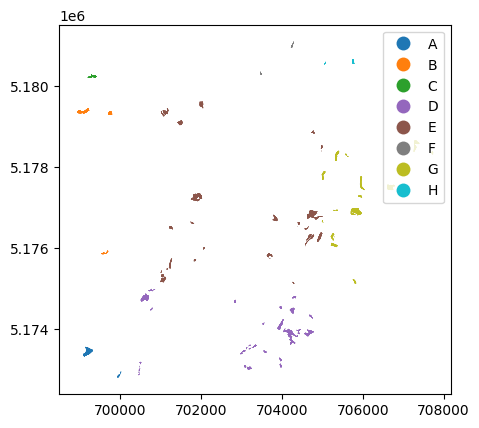

In [460]:
print(lai_df["block"].unique())
lai_df.plot(column="block", legend=True)

In [461]:
# Clean data
groups = lai_df["block"]
#X = lai_df.drop(["x","y", "block", 'lai_mean', 'lai_sum', 'farm'], axis=1)
#y = lai_df['lai_mean']
X = lai_df.drop(["x","y", "block", 'lai', 'lai', 'farm',"spatial_ref", "time"], axis=1) 
y = lai_df['lai']

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Spatial cross validation
cv = GroupKFold(n_splits=5)
scores = cross_val_score(model, X, y, cv=cv, groups=groups, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-scores)

print("Spatial CV RMSE scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())


mae_scores = cross_val_score(model, X, y, cv=cv, groups=groups, scoring="neg_mean_absolute_error")

print("Spatial CV MAE scores:", -mae_scores)

Spatial CV RMSE scores: [1.4248061  1.21659264 1.18922454 1.31009262 1.48878088]
Mean RMSE: 1.3258993561384298
Spatial CV MAE scores: [1.15238805 0.99008038 0.93619063 1.07899139 1.21751785]


#### Feature importance

In [462]:
# Clean data
groups = lai_df["block"]
# X = lai_df.drop(["x","y", "block", 'lai_mean', 'lai_sum', 'farm',"Day_of_Year"], axis=1)
# y = lai_df['lai_mean']
X = lai_df.drop(["x","y", "block", 'lai', 'farm',"time", "Day_of_Year", "spatial_ref"], axis=1)
y = lai_df['lai']


# spatial CV
group_kfold = GroupKFold(n_splits=2)

for i, (tr_idx, val_idx) in enumerate(group_kfold.split(X, y, groups)):
    # spliting the data
    X_train, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    # Fit THE model
    model = RandomForestRegressor(random_state=2025)
    model.fit(X_train, y_train)
    
    # Making predictions
    y_pred = model.predict(X_val)

    print("MSE:", mean_squared_error(y_val, y_pred))
    print("RMSE:", root_mean_squared_error(y_val, y_pred))
    break
    

MSE: 2.263806806740503
RMSE: 1.5045952301999708


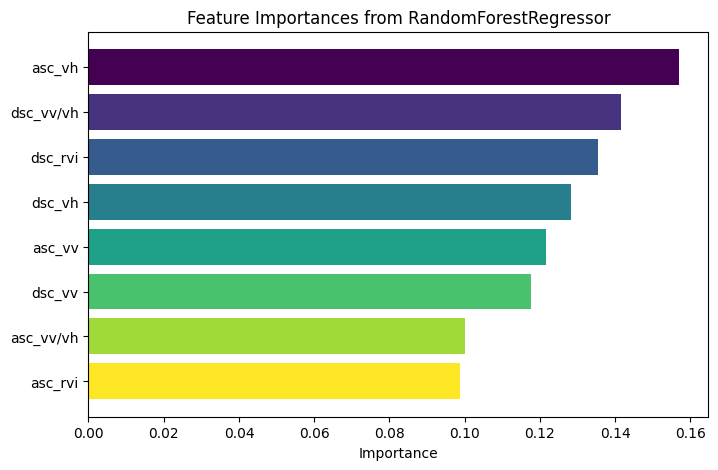

In [463]:
# Get feature importances
importances = model.feature_importances_
feature_names = model.feature_names_in_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot feature importances
colors = cm.viridis(np.linspace(0, 1, len(importance_df)))
plt.figure(figsize=(8, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color=colors)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importances from RandomForestRegressor")
plt.show()